# Convolutional Neural Networks for Sentence Classification

# Reviews Dataset

In [1]:
import pathlib
import random
import itertools
import torch
from typing import Any


MOVIE_REVIEW_DIR = pathlib.Path('data/movie_reviews/txt_sentoken/')

def pick_device() -> torch.device:
    if torch.backends.mps.is_available():  
        print("Using GPU")     
        return torch.device("mps")
    print('No GPU available, using the CPU instead.')
    return torch.device("cpu")

device = torch.device("cpu")


def load_reviews(path: pathlib.Path) -> list[str]:
    """Build movie review training set from the dataset directory"""
    x = []
    for filename in path.glob("*.txt"):
        with filename.open() as f:
            x.extend(f.readlines())
    return x

def tokenize(sentence: str) -> list[str]:
    """Tokenize the sentence into words."""
    return sentence.lower().split(' ')


MAX_SENTENCE_LEN = 30  # Assumes only first N elements are allowed


def build_vocab(contents: list[str]) -> dict[str, int]:
    """Build an index of words to token number."""
    vocab: dict[str, int] = {}
    vocab['</s>'] = 0
    index = 1
    for line in load_reviews(MOVIE_REVIEW_DIR / "pos") + load_reviews(MOVIE_REVIEW_DIR / "neg"):
        tokens = tokenize(line)
        for word in itertools.islice(tokens, MAX_SENTENCE_LEN):
            if word not in vocab:
                vocab[word] = index
                index += 1
    return vocab


vocab = build_vocab(load_reviews(MOVIE_REVIEW_DIR / "pos") + load_reviews(MOVIE_REVIEW_DIR / "neg"))
vocab_inv = { v: k for k, v in vocab.items()}


def encode_sentence(sentence: str) -> torch.tensor:
    """Encode a sentence as a series of token indexes."""
    encoded = [ vocab.get(word.lower(), 0) for word in itertools.islice(tokenize(sentence), MAX_SENTENCE_LEN) ]
    if len(encoded) < MAX_SENTENCE_LEN:
        encoded.extend([0] * (MAX_SENTENCE_LEN - len(encoded)))
    return torch.tensor(encoded, device=device)


reviews: list[tuple[str, Any]] = []
for review in load_reviews(MOVIE_REVIEW_DIR / "pos"):
    reviews.append((encode_sentence(review), (0.0, 1.0)))
for review in load_reviews(MOVIE_REVIEW_DIR / "neg"):
    reviews.append((encode_sentence(review), (1.0, 0.0)))

print(f"Vocab size: {len(vocab)}")
print(f"Num reviews: {len(reviews)}")

Vocab size: 47431
Num reviews: 64720


# word2vec

In [2]:
import numpy
import torch
from tqdm import tqdm


WORD2VEC = 'data/GoogleNews-vectors-negative300.bin'
MAX_WORDLEN = 50
WEIGHT_SIZE = 4
WORD_SIZE = 300  # Embedding size


def load_word2vec(vocab: dict[str, int]) -> torch.tensor:
    vocab_vec = numpy.random.uniform(-0.25, 0.25, (len(vocab), WORD_SIZE))
    #vocab_vec[0] = torch.rand(WORD_SIZE) - 0.5
    with open(WORD2VEC, 'rb') as fd:
        line = fd.readline()
        parts = line.decode('utf-8').split(' ')
        words = int(parts[0])
        word_size = int(parts[1])
        if word_size != WORD_SIZE:
            raise ValueError(f"Unexpected word size {word_size} != {WORD_SIZE}")
        for i in tqdm(range(0, words)):
            # Read the next word
            s = b''
            while True:
                ch = fd.read(1)
                if ch == b' ':
                    break
                if ch == b'':
                    raise ValueError("Unexpected eof")
                if ch != b'\n':
                    s += ch
                if len(s) > word_size:
                    raise ValueError(f"Word was too long {s}")
            weights = fd.read(word_size * WEIGHT_SIZE)
            wd = numpy.frombuffer(weights, dtype=numpy.float32)
            word = s.decode('utf-8').strip().lower()
            # Only load words in the vocabulary
            if (idx := vocab.get(word)) is not None:
                vocab_vec[idx] = wd
    return torch.tensor(vocab_vec, dtype=torch.float32, device=device)


vocab2vec = load_word2vec(vocab)
len(vocab), len(vocab2vec)

100%|██████████| 3000000/3000000 [00:07<00:00, 418815.83it/s]


(47431, 47431)

In [3]:
def word2vec(word: str) -> torch.Tensor:
    """Lookup the word using the word2vec encoding or init to random."""
    if word not in vocab:
        word = '</s>'
    idx = vocab[word]
    return vocab2vec[idx]


# Sample from word2vec
print("Example:")
print(min(word2vec('car')))
print(max(word2vec('car')))

print("Sentence example:")
print(tokenize("My car is a bus"))
print(encode_sentence("My car is a bus"))

Example:
tensor(-0.2305)
tensor(0.2539)
Sentence example:
['my', 'car', 'is', 'a', 'bus']
tensor([ 297,  561,    7,   40, 6821,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0])


In [4]:
import torch

# From the paper: The input is a concatenated sentence (length n) where each word is
# represented as a k-dimensional word vector. X[i, i+j] = concat(Xi, Xi+1, ..., Xi+j)
# The sentence is padded where necessary.


def build_dataset(dataset: list[tuple[str, Any]]) -> tuple[torch.Tensor, torch.Tensor]:
    x, y = [], []
    for (data, class1) in dataset:
        x.append(data)
        y.append(class1)
    X = torch.stack(x)
    Y = torch.tensor(y, device=device)
    return X, Y


random.seed(31337)
random.shuffle(reviews)
n1 = int(0.8*len(reviews))
n2 = int(0.9*len(reviews))

Xtr, Ytr = build_dataset(reviews[:n1])
Xdev, Ydev = build_dataset(reviews[n1:n2])
Xte, Yte = build_dataset(reviews[n2:])

Xtr.shape, Ytr.shape

(torch.Size([51776, 30]), torch.Size([51776, 2]))

In [5]:
r1 = reviews[5][0]
r2 = reviews[5][0]
print((r1.shape, r2.shape))
torch.stack([r1, r2]).shape

(torch.Size([30]), torch.Size([30]))


torch.Size([2, 30])

# Model

In [6]:
import torch.nn as nn
import torch.nn.functional as F

FILTER_WINDOWS = (3, 4, 5)
FEATURE_MAPS = 100


class Model(nn.Module):
    """A model for training a CNN text classifier."""

    def __init__(self, embeddings: torch.tensor, num_classes: int, dropout: float = 0.5):
        """Initialize Model."""
        super().__init__()
        self.vocab_size, self.embed_dim = embeddings.shape
        self.embedding = nn.Embedding.from_pretrained(embeddings, freeze=True).float()
        self.embedding.requires_grad = False
        self.conv_list = nn.ModuleList([
            nn.Conv1d(
                in_channels=self.embed_dim,
                out_channels=FEATURE_MAPS,
                kernel_size=filter_size,
            )
            for filter_size in FILTER_WINDOWS
        ])
        self.fc = nn.Linear(FEATURE_MAPS * len(FILTER_WINDOWS), num_classes)
        self.dropout = nn.Dropout(p=dropout)


    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward pass"""
        # Out: (BATCH_SZ, MAX_SENTENCE_LEN, WORD_SIZE)
        self.x_embed = self.embedding(x)
        # Reshape to match conv1d input
        # Out: (BATCH_SZ, WORD_SIZE, MAX_SENTENCE_LEN)
        self.x_reshape = self.x_embed.permute(0, 2, 1) 
        # (BATCH_SZ, FEATURE_MAPS, MAX_SENTENCE_LEN-2)
        # (BATCH_SZ, FEATURE_MAPS, MAX_SENTENCE_LEN-3)
        # (BATCH_SZ, FEATURE_MAPS, MAX_SENTENCE_LEN-4)
        self.x_conv_list = [F.relu(conv(self.x_reshape)) for conv in self.conv_list]
        # (BATCH_SZ, FEATURE_MAPS, 1)
        self.x_pool_list = [
            F.max_pool1d(x_conv, kernel_size=x_conv.shape[2])
            for x_conv in self.x_conv_list
        ]
        # (BATCH_SZ, FEATURE_MAPS * 3)
        self.x_fc = torch.cat([x_pool.squeeze(dim=2) for x_pool in self.x_pool_list], dim=1)
        # (BATCH_SZ, FEATURE_MAPS * 3)
        #self.logits = self.fc(self.dropout(self.x_fc))
        self.logits = self.fc(self.dropout(self.x_fc))
        self.logits_class = F.softmax(self.logits, dim=1)
        return self.logits_class

    def __str__(self) -> str:
        return self.__class__.__name__

# Training

In [17]:
from tqdm import tqdm
import math

MINI_BATCH_SZ = 128

device = torch.device("cpu")
gpu_device = pick_device()

g = torch.Generator(device=device).manual_seed(31337)

model = Model(embeddings=vocab2vec, num_classes=2, dropout=0.5)
model.to(gpu_device)
model.train()

lr = 0.1
opt = torch.optim.Adadelta(model.parameters(), lr=lr, rho=0.95)


def eval(X: torch.Tensor, Y: torch.Tensor) -> tuple[float, float]:
    model.eval()
    lossi = []
    accuracyi = []
    pbar = tqdm(range(len(X) // EVAL_BATCH_SIZE))
    for i in pbar:
        ix = torch.randint(0, X.shape[0], (EVAL_BATCH_SIZE,), generator=g, device=device) # (EVAL_BATCH_SIZE)
        Xb, Yb = X[ix].to(gpu_device), Y[ix].to(gpu_device)
        logits = model.forward(Xb)
        loss = F.cross_entropy(logits, Yb)
        lossi.append(loss.item())
        accuracy = (torch.round(logits) == Yb).cpu().numpy().mean() * 100
        accuracyi.append(accuracy)
        pbar.set_description(f"Eval Loss: {loss:0.4f}, Acc: {accuracy:0.4f}")
    l, a = torch.mean(torch.tensor(lossi)), torch.mean(torch.tensor(accuracyi))
    pbar.set_description(f"Eval Loss: {l:0.4f}, Acc: {a:0.4f}")
    return l, a

stepi = []
lossi = []
loglossi = []
logits_history = []
accuracyi = []

Xtr = Xtr.to(gpu_device)
Ytr = Ytr.to(gpu_device)
xdev_loss, xdev_accuracy = 0, 0

for epoch in range(0, 20):
    model.train()

    pbar = tqdm(range(1500))
    for i in pbar:
        ix = torch.randint(0, Xtr.shape[0], (MINI_BATCH_SZ,), generator=g, device=device) # (MINI_BATCH_SZ)
        Xb, Yb = Xtr[ix].to(gpu_device), Ytr[ix].to(gpu_device)

        model.zero_grad()
        logits = model.forward(Xb)

        loss = F.cross_entropy(logits, Yb)
        loss.backward()
        opt.step()

        accuracy = (torch.round(logits) == Yb).cpu().numpy().mean() * 100

        stepi.append(i)
        lossi.append(loss.item())
        loglossi.append(loss.log10().item())
        accuracyi.append(accuracy)
        if i % 100 == 0:
            pbar.set_description("[%d], Train Loss %0.4f Acc: %0.4f)" % (epoch, lossi[-1], accuracy))

    xdev_loss, xdev_accuracy = eval(Xdev, Ydev)

       

Using GPU


Eval Loss: 0.6265, Acc: 66.9000: 100%|██████████| 6/6 [00:00<00:00, 15.63it/s]


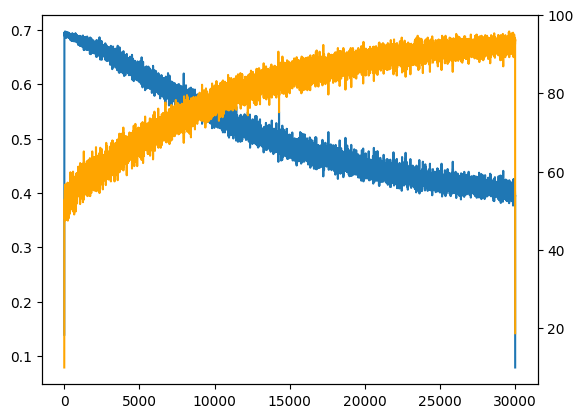

In [18]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

WINDOW = 5

plt.plot(np.convolve(lossi, np.ones(WINDOW)) / WINDOW)
plt.gca().twinx().plot(np.convolve(accuracyi, np.ones(WINDOW)) / WINDOW, color="orange")

# Eval

In [20]:
xtr_loss, xtr_accuracy = eval(Xtr, Ytr)
xdev_loss, xdev_accuracy = eval(Xdev, Ydev)

loss: 0.6263, accuracy: 65.6000: 100%|██████████| 6/6 [00:00<00:00, 16.50it/s]


# Prediction

In [21]:

model.eval()

def predict(text: str) -> None:
    """Predict probability that a review is positive."""

    encoded = encode_sentence(text).to(gpu_device)
    input_data = encoded.unsqueeze(dim=0)

    # Compute logits
    with torch.no_grad():
        logits = model.forward(input_data)

    # Compute probability
    prob = logits.squeeze(dim=0)
    print(f"This review is {prob[1] * 100:.2f}% positive.")


predict("All of friends slept while watching this movie, but I really enjoyed it.")
predict("I have waited so long for this movie and I am now so satisfied and happy.")
predict("This is a great movie")
predict("I was laughing the whole time")
predict("Fantastic movie that I would watch again")
print("---")
predict("This movie is long and boring.")
predict("I don't like the ending.")
predict("Do not bother watching this movie.")
predict("Not a funny comedy")



This review is 37.21% positive.
This review is 3.51% positive.
This review is 72.89% positive.
This review is 16.85% positive.
This review is 50.24% positive.
---
This review is 87.02% positive.
This review is 23.06% positive.
This review is 9.63% positive.
This review is 5.40% positive.
